<a href="https://colab.research.google.com/github/kmaciver/Ryerson_Capstone/blob/master/FinalModel/Step4-DayTrade_DailySummaryInputs/DayTradeSingle_DFSDInput_(Final_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM, TimeDistributed, Lambda, Dropout
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import losses
import warnings
warnings.filterwarnings('ignore')
import random as rand
from random import randint
from numpy.random import seed
seed(10)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(2)


In [11]:
file_path = "/content/drive/My Drive/Capstone/Data Exploration/Day_trade_data.csv"
DayTrade = pd.read_csv(file_path, index_col='Time')
DayTrade = DayTrade.drop([DayTrade.columns[0]] ,  axis='columns')
DayTrade.head()

,Open,High,Low,Close,Volume_.BTC.,Volume_.Currency.,Weighted_Price,date,Open_RoC,High_RoC,Low_RoC,Close_RoC,Weighted_Price_RoC,RSI,MACD_index,slow_stoch
Time,,,,,,,,,,,,,,,,
2013-04-03 00:00:00,116.00,116.00,116.00,116.00,31.713233,3678.735005,116.000000,2013-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,33.333333,-0.36038,0.084906
2013-04-03 00:01:00,116.00,116.00,116.00,116.00,31.713233,3678.735005,116.000000,2013-04-03,0.000000,0.000000,0.000000,0.000000,0.000000,33.333333,-0.36038,0.084906
2013-04-03 00:02:00,116.00,116.58,116.00,116.58,2.050985,238.357034,116.215883,2013-04-03,0.000000,0.004988,0.000000,0.004988,0.001859,33.333333,-0.36038,0.084906
2013-04-03 00:03:00,116.98,117.00,116.98,117.00,23.000000,2690.890000,116.995217,2013-04-03,0.008413,0.003596,0.008413,0.003596,0.006684,33.333333,-0.36038,0.084906
2013-04-03 00:04:00,117.00,117.00,117.00,117.00,50.000000,5850.000000,117.000000,2013-04-03,0.000171,0.000000,0.000171,0.000000,0.000041,33.333333,-0.36038,0.084906


Dropping Volume Currency as discussed in the Feature Selection phase

In [0]:
DayTrade = DayTrade.drop(columns='Volume_.Currency.')

In [13]:
#We need create a target data, which is basically a copy of the data that will be later shifted
target_data = DayTrade.copy()
target_data = target_data.iloc[:,5:7]
target_data.head()

,Weighted_Price,date
Time,,
2013-04-03 00:00:00,116.000000,2013-04-03
2013-04-03 00:01:00,116.000000,2013-04-03
2013-04-03 00:02:00,116.215883,2013-04-03
2013-04-03 00:03:00,116.995217,2013-04-03
2013-04-03 00:04:00,117.000000,2013-04-03


The objective of the model is to predict 10 minutes ahead of the current timestep. The Day Trade data contains the minute to minute data for a total of 1735 days. The analysis must be limited within each day.

In [0]:
# Predict 10 minutes in the future, although the predictions must be wrapped around each day
shift_steps = 10

# Now that the target_data was created we need to shift the data so that the target values of 24 hours later aling with our
# input data

target_data = target_data.groupby('date').shift(-shift_steps)


Here we double check that because we shifted the target values now we have NaN values at the end

In [15]:
target_data.iloc[1420:1450]

,Weighted_Price
Time,
2013-04-03 23:40:00,129.900000
2013-04-03 23:41:00,129.900000
2013-04-03 23:42:00,129.899861
2013-04-03 23:43:00,129.892440
2013-04-03 23:44:00,130.049341
2013-04-03 23:45:00,131.371316
2013-04-03 23:46:00,132.534018
2013-04-03 23:47:00,132.912123
2013-04-03 23:48:00,132.819273


In [0]:
# Now we need to remove the rows with NaN values for the target data thus needing to exclude also the 
# 10 lines per day of the DayTrade data

DayTrade['target'] = target_data['Weighted_Price']

target_data['date'] = DayTrade['date']

DayTrade_clean = DayTrade.dropna()
target_data_clean = target_data.dropna()

In [17]:
DayTrade_clean.shape, target_data_clean.shape

((2481050, 16), (2481050, 2))

Number of rows for both data are correct since initially the data consisted of 1735 days of 1440 minutes (total of 2.481.050 rows) and now each day had the last 10 minutes so the total amount of rows must be 1735 days of 1430 minutes (total of 2.481.050)

In [0]:
# the target column was only added to the DayTrade data in order to drop the correct rows.
#Removing column 'target' from the DayTrade data

DayTrade = DayTrade.drop(columns='target')
DayTrade_clean = DayTrade_clean.drop(columns='target')

## Adding prediction for High and Low based on Daily Summary 

The daily summary was used to predict the high and low price of the next day. This values will then be used by the algorithm to try to reduce the variance of the prediction

In [12]:
# Each day of the DayTrade data must have a prediction for what is the current day high and low price expectation

#Load DailySummary data
file_path = "/content/drive/My Drive/Capstone/Data Exploration/DSFD.csv"
DaySummary = pd.read_csv(file_path, index_col='date')
DaySummary = DaySummary.drop([DaySummary.columns[0]] ,  axis='columns')
DaySummary = DaySummary.drop(columns=['Volume_Currency','Close_RoC'])

target_dataDaySummary = DaySummary.copy()
target_dataDaySummary = target_dataDaySummary.loc[:,['High','Low']]

shift_steps = 1
target_dataDaySummary = target_dataDaySummary.shift(-shift_steps)

DaySummary_clean = DaySummary.iloc[:-1,:]
target_dataDaySummary_clean = target_dataDaySummary.iloc[:-1,:]

X_data = np.array(DaySummary_clean)
Y_data = np.array(target_dataDaySummary_clean)

train_split = 0.9

n_train_rows = int(X_data.shape[0]*train_split)

X_train = X_data[0:n_train_rows]
Y_train = Y_data[0:n_train_rows]

#Create Scalers and fit them
x_scaler = MinMaxScaler()
x_scaler.fit(X_train)

y_scaler = MinMaxScaler()
y_scaler.fit(Y_train)


# Scale X_data, rechape and transform it into Batches for prediction
X_data_scaled = x_scaler.transform(X_data)
X_data_scaled  = X_data_scaled.reshape(1,X_data_scaled.shape[0],X_data_scaled.shape[1])

#Create Batches for the X_data
sequence_length = 25
num_x_signal = 13
num_y_signal = 2

# Allocate a new array for the batch of input-signals.
batch_size_val = X_data_scaled.shape[1] - sequence_length 

x_shape = (batch_size_val, sequence_length, num_x_signal)
x_batch = np.zeros(shape=x_shape, dtype=np.float16)

# Fill the batch with random sequences of data.
for i in range(batch_size_val):
    # Copy the sequences of data starting at this index.
    x_batch[i] = X_data_scaled[0][i:i+sequence_length][:]
    
#load model for prediction 
DSFD_modelFilePath = "/content/drive/My Drive/Capstone/FinalModels/Step3-DailySummary/DailySummary_LSTM_trained.h5"
loaded_model = tf.keras.models.load_model(DSFD_modelFilePath)  

#Generate the prediction   
ypred = loaded_model.predict(x_batch)
ypred_rescaled = y_scaler.inverse_transform(ypred)

#Create columns of prediction for DaySummary data
DaySummary['High_Pred'] = np.nan
DaySummary['Low_Pred'] = np.nan


#Copy the prediction values to the DauSummary Data
DaySummary.High_Pred[26:] =  ypred_rescaled[:,0]
DaySummary.Low_Pred[26:] =  ypred_rescaled[:,1]

In [0]:
# Now that DaySummary has predictions High and Low predictions for the day, it is necessary to copy those prediction into the 
# DayTrade data

DaySummary_clean = DaySummary.copy()
DaySummary_clean.dropna()

days_in_DailySummary = list(dict.fromkeys(DaySummary_clean.index.values))
days_in_data = list(dict.fromkeys(DayTrade_clean["date"].values))
days_with_predictions = list(set(days_in_data).intersection(days_in_DailySummary))

DayTrade_clean['High_Pred'] = np.nan
DayTrade_clean['Low_Pred'] = np.nan

for day in days_with_predictions:
    DayTrade_clean.High_Pred[DayTrade_clean['date'].values==day] = np.array(DaySummary_clean.High_Pred[DaySummary_clean.index==day])
    DayTrade_clean.Low_Pred[DayTrade_clean['date'].values==day] = np.array(DaySummary_clean.Low_Pred[DaySummary_clean.index==day])    


In [14]:
DayTrade_clean = DayTrade_clean.dropna()
DayTrade_clean.shape

(2453880, 17)

In [15]:
DayTrade_clean.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_.BTC.', 'Weighted_Price',
       'date', 'Open_RoC', 'High_RoC', 'Low_RoC', 'Close_RoC',
       'Weighted_Price_RoC', 'RSI', 'MACD_index', 'slow_stoch', 'High_Pred',
       'Low_Pred'],
      dtype='object')

In [19]:
DayTrade_clean.tail(10)

,Open,High,Low,Close,Volume_.BTC.,Weighted_Price,date,Open_RoC,High_RoC,Low_RoC,Close_RoC,Weighted_Price_RoC,RSI,MACD_index,slow_stoch,High_Pred,Low_Pred
Time,,,,,,,,,,,,,,,,,
2019-08-11 23:40:00,11528.20,11532.86,11505.84,11505.97,2.049550,11527.942145,2019-08-11,0.000680,0.001084,-0.000536,-0.000525,0.001007,46.910718,0.005368,0.436299,11879.370117,11216.633789
2019-08-11 23:41:00,11522.45,11522.45,11519.16,11519.16,3.455912,11521.067360,2019-08-11,-0.000499,-0.000903,0.001157,0.001146,-0.000597,53.438167,0.005437,0.414254,11879.370117,11216.633789
2019-08-11 23:42:00,11522.10,11524.83,11522.10,11524.83,0.220695,11522.285170,2019-08-11,-0.000030,0.000207,0.000255,0.000492,0.000106,55.945707,0.007044,0.458960,11879.370117,11216.633789
2019-08-11 23:43:00,11519.26,11519.26,11510.00,11510.00,5.479156,11510.019621,2019-08-11,-0.000247,-0.000483,-0.001051,-0.001288,-0.001065,48.577001,0.007458,0.524607,11879.370117,11216.633789
2019-08-11 23:44:00,11518.83,11533.19,11518.83,11518.83,0.301245,11521.713463,2019-08-11,-0.000037,0.001209,0.000767,0.000767,0.001015,52.581741,0.008309,0.573885,11879.370117,11216.633789
2019-08-11 23:45:00,11518.00,11525.85,11518.00,11525.85,0.037464,11518.097327,2019-08-11,-0.000072,-0.000637,-0.000072,0.000609,-0.000314,55.545825,0.010345,0.585729,11879.370117,11216.633789
2019-08-11 23:46:00,11525.85,11545.00,11525.85,11536.46,2.692778,11532.658016,2019-08-11,0.000681,0.001660,0.000681,0.000920,0.001263,59.651077,0.014460,0.635066,11879.370117,11216.633789
2019-08-11 23:47:00,11537.75,11539.04,11537.75,11539.04,1.353892,11538.087191,2019-08-11,0.001032,-0.000516,0.001032,0.000224,0.000471,60.603809,0.019988,0.713420,11879.370117,11216.633789
2019-08-11 23:48:00,11535.84,11544.18,11531.55,11532.27,0.369848,11532.563833,2019-08-11,-0.000166,0.000445,-0.000538,-0.000587,-0.000479,56.812934,0.025128,0.779253,11879.370117,11216.633789


In [0]:
DayTrade_clean.to_csv('/content/drive/My Drive/Capstone/FinalModels/Step4-DayTrade_DailySummaryInputs/DayTrade_clean.csv')

In [0]:
DayTrade_clean = pd.read_csv('/content/drive/My Drive/Capstone/FinalModels/Step4-DayTrade_DailySummaryInputs/DayTrade_clean.csv', index_col='Time')

By adding the High and Low predictions from the Daily Summary data and removing the NaN the data now has 2.453.880 rows (which corresponds to 1716 days), which means 19 days of the original data lied before the 25 first days that the Daily Summary data needed to begin making predictions

## Continuing with Day Trade Analysis 

In order to compare results with other models the same dates for testing must be used

In [20]:
# Previous algorithm used 174 days for testing
days_in_data = list(dict.fromkeys(DayTrade_clean["date"].values))

training_days = days_in_data[:len(days_in_data)-174]
testing_days = days_in_data[len(days_in_data)-174:]

print(len(training_days),len(testing_days))

1542 174


Data will need to be normalized for predictions. A scaler will be fitted for the training data

In [21]:
#Step 1 - Convert day data into numpy array
train_data = np.array(DayTrade_clean.loc[DayTrade_clean.date.isin(training_days),:].drop(columns='date'))
label_data = np.array(target_data_clean.loc[target_data_clean.date.isin(training_days),:].drop(columns='date')).reshape(-1,1)

#Step 2 - Scale data for Neural Network
x_scaler = MinMaxScaler()
x_scaler.fit(train_data)
y_scaler = MinMaxScaler()
y_scaler.fit(label_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
def batch_reshape(sequence_length, X_train_scale, Y_train_scale, num_x_signal, num_y_signal):
    """
    Generator function for creating random batches of training-data.
    """
    batch_size = X_train_scale.shape[1] // sequence_length
    # Allocate a new array for the batch of input-signals.
    x_shape = (batch_size, sequence_length, num_x_signal)
    x_batch = np.zeros(shape=x_shape, dtype=np.float16)
    
 
    # Allocate a new array for the batch of output-signals.
    y_shape = (batch_size, num_y_signal)
    y_batch = np.zeros(shape=y_shape, dtype=np.float16)

    #print(x_batch.shape, y_batch.shape, X_train_scale.shape, Y_train_scale.shape) #debugging
    # Create Sequence for sliding window
    seq = []
    for i in range(batch_size):
        seq.append(i*sequence_length)
    
    # Fill the batch with sequences of data.
    for i in range(0,len(seq)-1):

        # Copy the sequences of data starting at this index.
        x_batch[i] = X_train_scale[0][seq[i]:seq[i]+sequence_length][:]
        y_batch[i] = Y_train_scale[0][seq[i]+sequence_length-1][:]
        #print("iteration: ",i,"-OK") #debugging

    #print(x_batch.shape,y_batch.shape) #debbuging
    return (x_batch, y_batch)

In [0]:
def batch_generator(batch_size, sequence_length, num_x_signal, num_y_signal, train_data, label_data, training_days):
    
    # Create a Batch function for training data using sliding window technique
    # Step 1 - Select a training day

    day = rand.choice(training_days)

    #Step 2 - Filter Input data and Target with the selected date
    day_train_data = train_data[train_data['date'].values==day]
    day_label_data = label_data[label_data['date'].values==day]

    #Step 3 - Drop date columns from day train data and day label data
    day_train_data = day_train_data.drop(columns='date')
    day_label_data = day_label_data.drop(columns='date')

    #Step 4 - Convert day data into numpy array
    day_train_data = np.array(day_train_data)
    day_label_data = np.array(day_label_data).reshape(-1,1)

    #Step 5 - Scale data for Neural Network
    day_train_data = x_scaler.transform(day_train_data)
    day_label_data = y_scaler.transform(day_label_data)

    #Step 6 - Reshape data to fit keras requirement to have a (x,y,z) shape
    day_train_data = day_train_data.reshape(1,day_train_data.shape[0],day_train_data.shape[1])
    day_label_data = day_label_data.reshape(1,day_label_data.shape[0],day_label_data.shape[1])
    
     #Step 7 - Reshape data into Batches
    day_train_data_reshape , day_label_data_reshape =  batch_reshape(sequence_length, day_train_data, day_label_data, num_x_signal, num_y_signal)
    
    # print(day_train_data_reshape.shape , day_train_data_reshape.shape)#debugging
   
    #Step 8 - Apply the "jumping" slidding window technique to the reshaped date
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signal)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, num_y_signal)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random continuous sequences of data.

        # Get a random start-index.
        # This points somewhere into the training-data.
        idx = np.random.randint(day_train_data_reshape.shape[0] - batch_size)

        # Copy the sequences of data starting at this index.
        x_batch = day_train_data_reshape[idx:idx+batch_size]
        y_batch = day_label_data_reshape[idx:idx+batch_size]


        yield (x_batch, y_batch)



In [0]:
num_x_signal = 16 # number of input features
num_y_signal = 1 # number of label classes

batch_size = 50 # tunning parameter
sequence_length = 25 #Amount of time-steps to look back for the 10 minute prediction

In [0]:
generator = batch_generator(batch_size,sequence_length, num_x_signal, num_y_signal, DayTrade_clean, target_data_clean,training_days)

In [0]:
x_batch, y_batch = next(generator)

In [124]:
print(x_batch.shape)
print(y_batch.shape)

(50, 25, 16)
(50, 1)


In [0]:

def batch_validation(sequence_length, num_x_signal, num_y_signal, test_data, label_test_data, testing_days):
    
    # Create a Batch function for validation data using sliding window technique
    # Step 1 - Select a testing day

    day = rand.choice(testing_days)

    #Step 2 - Filter Input data and Target with the selected date
    day_test_data = test_data[test_data['date'].values==day]
    day_label_data = label_test_data[label_test_data['date'].values==day]

    #Step 3 - Drop date columns from day test data and day label data
    day_test_data = day_test_data.drop(columns='date')
    day_label_data = day_label_data.drop(columns='date')

    #Step 4 - Convert day data into numpy array
    day_test_data = np.array(day_test_data)
    day_label_data = np.array(day_label_data).reshape(-1,1)

    #Step 5 - Scale data for Neural Network
    day_test_data = x_scaler.transform(day_test_data)
    day_label_data = y_scaler.transform(day_label_data)

    #Step 6 - Reshape data to fit keras requirement to have a (x,y,z) shape
    day_test_data = day_test_data.reshape(1,day_test_data.shape[0],day_test_data.shape[1])
    day_label_data = day_label_data.reshape(1,day_label_data.shape[0],day_label_data.shape[1])
    
    #print(day_test_data.shape , day_label_data.shape)#debugging
    
    #Step 7 - Reshape data into Batches using slidding window   
    batch_val_size = day_test_data.shape[1] - sequence_length
    
    x_val_shape = (batch_val_size, sequence_length, num_x_signal)
    x_batch = np.zeros(shape=x_val_shape, dtype=np.float16)
        
    y_val_shape = (batch_val_size, num_y_signal)
    y_batch = np.zeros(shape=y_val_shape, dtype=np.float16)
    
    #print(x_batch.shape, y_batch.shape) # debugging
    for i in range(batch_val_size):

        # Copy the sequences of data starting at this index.
        x_batch[i] = day_test_data[0][i:i+sequence_length][:]
        y_batch[i] = day_label_data[0][i+sequence_length-1][:]

    
    return (x_batch, y_batch)

In [126]:
X_val, Y_val = batch_validation(sequence_length,num_x_signal, num_y_signal, DayTrade_clean, target_data_clean, testing_days)
print(X_val.shape, Y_val.shape)

(1405, 25, 16) (1405, 1)


In [0]:
validation_data = (X_val, Y_val)

## Create Recurrent Neural Network

In [128]:
from tensorflow.keras.layers import BatchNormalization


model = Sequential()
model.add(LSTM(units=200,
              return_sequences=True,
              input_shape=(None,num_x_signal,)))
model.add(LSTM(units=150, return_sequences=False))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(num_y_signal,activation='linear'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 200)         173600    
_________________________________________________________________
lstm_11 (LSTM)               (None, 150)               210600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 150)               600       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
Total params: 384,951
Trainable params: 384,651
Non-trainable params: 300
_________________________________________________________________


In [0]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

model.compile(loss=tf.keras.losses.logcosh, optimizer=optimizer)

In [0]:
model_file = "DayTrade with DailySummary Model(seed 10).{epoch:02d}-{val_loss:.4f}.h5"

mc = ModelCheckpoint('/content/drive/My Drive/Capstone/FinalModels/Step4-DayTrade_DailySummaryInputs/Seed 10/'+model_file, monitor="val_loss", mode="min", save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=1e-4)

In [132]:
%%time

history = model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=[ mc, reduce_lr])
                    #callbacks=[es, reduce_lr])

Epoch 1/100
50/50 [==============================] - 9s 177ms/step - loss: 0.3004 - val_loss: 0.0802 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 8s 163ms/step - loss: 0.0480 - val_loss: 0.0834 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 9s 170ms/step - loss: 0.0057 - val_loss: 0.0767 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 8s 164ms/step - loss: 0.0023 - val_loss: 0.0763 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 8s 164ms/step - loss: 0.0014 - val_loss: 0.0695 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 8s 162ms/step - loss: 9.3435e-04 - val_loss: 0.0704 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 8s 163ms/step - loss: 7.5363e-04 - val_loss: 0.0646 - lr: 0.0010
Epoch 8/100
50/50 [==============================] - 8s 163ms/step - loss: 7.0746e-04 - val_loss: 0.0573 - lr: 0.0010
Epoch 9/100
50/50 [==============================] - 8s 164ms/step - loss: 7

In [0]:

hist_df = pd.DataFrame(history.history) 
hist_csv_file = '/content/drive/My Drive/Capstone/FinalModels/Step4-DayTrade_DailySummaryInputs/Seed 10/'+model_file.split('.')[0]+'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

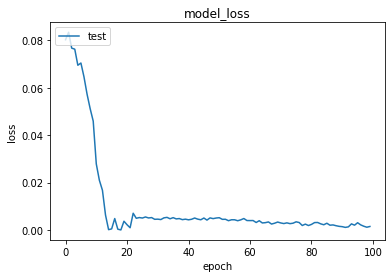

In [137]:
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

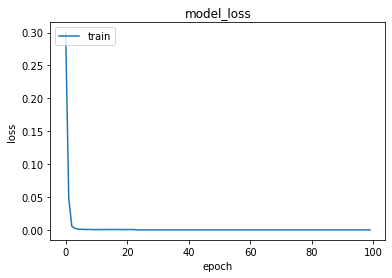

In [138]:
plt.plot(history.history['loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
# The algorithm uses data of the previous 25 time-steps to forecast the following 10th minute into the future. Therefore,  
# the first prediction of every day can only be excecuted after 25 minutes of the begining of the day, and will refer  
# to the prediction of the minute 35. Also the data is first stationarized by apply the diff() function with then subtracts
# the following row from the previous. 

# Since every day consists of 1440 minutes the algorithm is only able to predict the last 1404 minutes of the day.

#Create a Dataframe to hold the true predicted values for each day.
def createPredictionsData(days):  
  predictionsData = DayTrade.copy()
  predictionsData = predictionsData.loc[:,['Weighted_Price','date']]
  predictionsData = predictionsData[predictionsData['date'].isin(days)]# Filter only the testing days
  predictionsData = predictionsData.groupby('date').apply(lambda group: group.iloc[35:])# For each day filter the last 1405 minutes (1440 - 1405 = 35)
  predictionsData = predictionsData.drop(columns='date')
  predictionsData = predictionsData.reset_index()

  return(predictionsData)

In [0]:
def predict(modelFilename, days):

    predictionsData = createPredictionsData(days)
    
    column_name = modelFilename.split('.')[0]
    #Step 1 - Create a column to hold predictions
    predictionsData['Prediction_Weighted_Price'] = np.nan #[3]
    
    
    #Step 2 - load model for prediction   
    loaded_model = tf.keras.models.load_model(modelFilename)
    
    for day in days:
        #Step 3 - Filter Input data and Target with the selected date
        day_test_data = DayTrade_clean[DayTrade_clean['date'].values==day]
        day_label_data = target_data_clean[target_data_clean['date'].values==day]
        
        batch_size = len(day_test_data) - sequence_length
         
        
        #Step 3 - Drop date columns from day test data and day label data
        day_test_data = day_test_data.drop(columns=['date'])
        day_label_data = day_label_data.drop(columns=['date']).shift(1)

        #Step 4 - Convert day data into numpy array
        day_test_data = np.array(day_test_data)
        day_label_data = np.array(day_label_data)
        
        #Step 5 - Scale data for Neural Network (all features except Weighted Price)
        day_test_data = x_scaler.transform(day_test_data)
        day_label_data = y_scaler.transform(day_label_data)
        
               
        #Step 6 - Generate batches of sequence of data
        generator = TimeseriesGenerator(day_test_data, day_label_data, length=sequence_length, batch_size=batch_size)

        x_batch = np.zeros(shape=(batch_size ,sequence_length, num_x_signal))
        y_batch = np.zeros(shape=(batch_size ,sequence_length, num_y_signal))

        x_batch, y_batch = generator[0]

        #Step 9 - Generate the prediction for that day   
        ypred = loaded_model.predict(x_batch)
        ypred_rescaled = y_scaler.inverse_transform(ypred)
        
        index_list = []
        index_list = predictionsData.index[predictionsData['date']==day].tolist()

        predictionsData.iloc[index_list[0]:index_list[0]+len(index_list),3] = ypred_rescaled

    
    return(predictionsData)

In [0]:
model_file = 'DayTrade with DailySummary Model(seed 10).19-0.0001.h5'
modelPath = '/content/drive/My Drive/Capstone/FinalModels/Step4-DayTrade_DailySummaryInputs/Seed 10'
modelfilePath = modelPath + '/' + model_file

In [142]:
predictionsData = predict(modelfilePath, testing_days)
predictionsData

,date,Time,Weighted_Price,Prediction_Weighted_Price
0,2019-02-19,2019-02-19 00:35:00,3901.527342,3442.442139
1,2019-02-19,2019-02-19 00:36:00,3910.106934,3447.895752
2,2019-02-19,2019-02-19 00:37:00,3913.037224,3455.857666
3,2019-02-19,2019-02-19 00:38:00,3933.854943,3457.452148
4,2019-02-19,2019-02-19 00:39:00,3935.166985,3477.653076
...,...,...,...,...
244465,2019-08-11,2019-08-11 23:55:00,11550.565971,11963.412109
244466,2019-08-11,2019-08-11 23:56:00,11552.336234,11944.670898
244467,2019-08-11,2019-08-11 23:57:00,11555.520505,11903.083984
244468,2019-08-11,2019-08-11 23:58:00,11559.252199,11857.011719


In [0]:
# Save Dataframe with prediction as csv file
prediction_file = '/content/drive/My Drive/Capstone/FinalModels/Step4-DayTrade_DailySummaryInputs/Seed 10/'+'predictions_' +  model_file.split('.')[0] + '.csv'
prediction_filePath = '/content/' + prediction_file
predictionsData.to_csv(prediction_file)

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_Weighted_Price = mean_squared_error(predictionsData.iloc[:,2],predictionsData.iloc[:,3])
mae_Weighted_Price = mean_absolute_error(predictionsData.iloc[:,2],predictionsData.iloc[:,3])

In [145]:
print(mse_Weighted_Price,mae_Weighted_Price)

97924.4278082401 242.01179045603834
